## 1. Setup e Imports

In [12]:
import tensorflow as tf
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.10.0


## 2. Data Extraction y Preparation

Siguiendo el ciclo de ML, comenzamos con la extracción y preparación de datos.
Usaremos el dataset MNIST como ejemplo.

In [8]:
# Data Extraction
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

print(f"Training samples: {x_train.shape[0]}")
print(f"Test samples: {x_test.shape[0]}")
print(f"Image shape: {x_train.shape[1:]}")
print(f"Label range: {y_train.min()} - {y_train.max()}")

Training samples: 60000
Test samples: 10000
Image shape: (28, 28)
Label range: 0 - 9


### Data Analysis - Exploración de datos

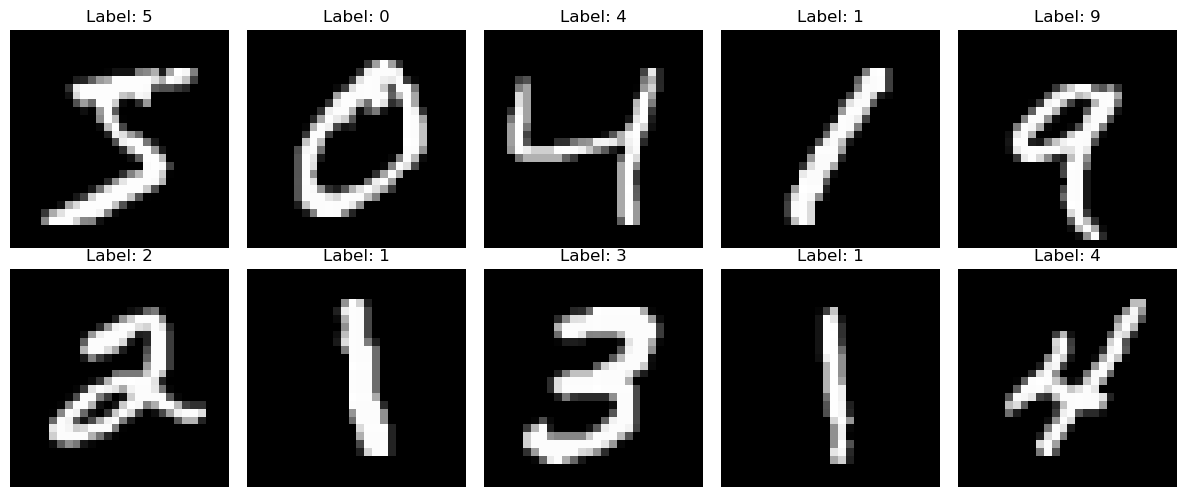


Distribución de clases en training:
  Dígito 0: 5923 muestras
  Dígito 1: 6742 muestras
  Dígito 2: 5958 muestras
  Dígito 3: 6131 muestras
  Dígito 4: 5842 muestras
  Dígito 5: 5421 muestras
  Dígito 6: 5918 muestras
  Dígito 7: 6265 muestras
  Dígito 8: 5851 muestras
  Dígito 9: 5949 muestras


In [13]:
# Visualizar algunos ejemplos
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(x_train[i], cmap='gray')
    ax.set_title(f"Label: {y_train[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

# Estadísticas básicas
print(f"\nDistribución de clases en training:")
unique, counts = np.unique(y_train, return_counts=True)
for label, count in zip(unique, counts):
    print(f"  Dígito {label}: {count} muestras")

### Data Preparation - Feature Engineering

Transformamos los datos a vectores numéricos normalizados (entre 0 y 1).

In [14]:
# Normalización: Min-Max scaling [0, 255] → [0, 1]
x_train_norm = x_train.astype('float32') / 255.0
x_test_norm = x_test.astype('float32') / 255.0

# Aplanar imágenes 28x28 → 784 features
x_train_flat = x_train_norm.reshape(-1, 28*28)
x_test_flat = x_test_norm.reshape(-1, 28*28)

print(f"Shape después de normalización y flatten: {x_train_flat.shape}")
print(f"Rango de valores: [{x_train_flat.min():.3f}, {x_train_flat.max():.3f}]")

Shape después de normalización y flatten: (60000, 784)
Rango de valores: [0.000, 1.000]


## 3. Creación de Datasets con tf.data

### 3.1 Dataset básico con from_tensor_slices

In [16]:
# Crear dataset básico desde tensores en memoria
dataset_basic = tf.data.Dataset.from_tensor_slices((x_train_flat, y_train))

print(f"Dataset creado: {dataset_basic}")
print(f"Tipo de elementos: {dataset_basic.element_spec}")

# Inspeccionar primeros elementos
for x, y in dataset_basic.take(3):
    print(f"\nFeatures shape: {x.shape}, Label: {y.numpy()}")

Dataset creado: <TensorSliceDataset element_spec=(TensorSpec(shape=(784,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))>
Tipo de elementos: (TensorSpec(shape=(784,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))

Features shape: (784,), Label: 5

Features shape: (784,), Label: 0

Features shape: (784,), Label: 4


### 3.2 Pipeline sin optimizaciones

In [18]:
# Pipeline simple: solo batch
BATCH_SIZE = 32

dataset_simple = tf.data.Dataset.from_tensor_slices((x_train_flat, y_train))
dataset_simple = dataset_simple.batch(BATCH_SIZE)

print(f"Dataset simple con batch: {dataset_simple}")

# Ver un batch
for x_batch, y_batch in dataset_simple.take(1):
    print(f"\nBatch shape: {x_batch.shape}")
    print(f"Labels en batch: {y_batch.numpy()[:10]}...")  # primeros 10

Dataset simple con batch: <BatchDataset element_spec=(TensorSpec(shape=(None, 784), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))>

Batch shape: (32, 784)
Labels en batch: [5 0 4 1 9 2 1 3 1 4]...


### 3.3 Pipeline optimizada con shuffle, batch y prefetch

In [19]:
def create_optimized_dataset(x, y, batch_size=32, shuffle_buffer=10000):
    """
    Crea un dataset optimizado con las mejores prácticas de tf.data
    
    - shuffle: evita patrones en los datos
    - batch: agrupa ejemplos para entrenamiento
    - prefetch: prepara siguiente batch mientras GPU trabaja
    """
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=shuffle_buffer)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset

# Crear datasets optimizados
train_dataset = create_optimized_dataset(x_train_flat, y_train, batch_size=BATCH_SIZE)
test_dataset = create_optimized_dataset(x_test_flat, y_test, batch_size=BATCH_SIZE, shuffle_buffer=1000)

print(f"Dataset optimizado: {train_dataset}")

Dataset optimizado: <PrefetchDataset element_spec=(TensorSpec(shape=(None, 784), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))>


### 3.4 Pipeline con transformaciones usando map()

In [20]:
def augment_data(x, y):
    """
    Función de transformación personalizada
    Agrega ruido gaussiano para data augmentation
    """
    noise = tf.random.normal(shape=tf.shape(x), mean=0.0, stddev=0.1)
    x_noisy = x + noise
    x_noisy = tf.clip_by_value(x_noisy, 0.0, 1.0)
    return x_noisy, y

# Dataset con transformaciones
train_dataset_augmented = tf.data.Dataset.from_tensor_slices((x_train_flat, y_train))
train_dataset_augmented = train_dataset_augmented.shuffle(10000)
train_dataset_augmented = train_dataset_augmented.map(
    augment_data, 
    num_parallel_calls=tf.data.AUTOTUNE  # Paralelización
)
train_dataset_augmented = train_dataset_augmented.batch(BATCH_SIZE)
train_dataset_augmented = train_dataset_augmented.prefetch(tf.data.AUTOTUNE)

print("Dataset con augmentation creado")

Dataset con augmentation creado


### 3.5 Uso de cache() para acelerar

In [21]:
# Dataset con cache para mantener transformaciones en memoria
train_dataset_cached = tf.data.Dataset.from_tensor_slices((x_train_flat, y_train))
train_dataset_cached = train_dataset_cached.cache()  # Cachea después de cargar
train_dataset_cached = train_dataset_cached.shuffle(10000)
train_dataset_cached = train_dataset_cached.batch(BATCH_SIZE)
train_dataset_cached = train_dataset_cached.prefetch(tf.data.AUTOTUNE)

print("Dataset con cache creado")

Dataset con cache creado


## 4. Model Training

Entrenamos un modelo simple para comparar diferentes pipelines.

In [22]:
def create_model():
    """
    Crea un modelo de red neuronal simple
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(784,)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Crear modelo
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               100480    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________
__________________________________________________

### 4.1 Entrenamiento con dataset optimizado

In [23]:
# Entrenar modelo
print("Entrenando con dataset optimizado...")

start_time = time.time()

history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=test_dataset,
    verbose=1
)

training_time = time.time() - start_time
print(f"\nTiempo total de entrenamiento: {training_time:.2f} segundos")

Entrenando con dataset optimizado...
Epoch 1/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3294 - accuracy: 0.9013 - val_loss: 0.1364 - val_accuracy: 0.9598
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3294 - accuracy: 0.9013 - val_loss: 0.1364 - val_accuracy: 0.9598
Epoch 2/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1654 - accuracy: 0.9505 - val_loss: 0.1041 - val_accuracy: 0.9680
Epoch 3/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1654 - accuracy: 0.9505 - val_loss: 0.1041 - val_accuracy: 0.9680
Epoch 3/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1299 - accuracy: 0.9614 - val_loss: 0.0940 - val_accuracy: 0.9704
Epoch 4/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1299 - accuracy: 0.9614 - val_loss: 0.0940 - val_accuracy: 0.9704
Epoch 4/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1082 - accuracy: 0.9667 - va

### 4.2 Comparación de velocidad entre pipelines

In [24]:
def measure_dataset_speed(dataset, num_batches=100):
    """
    Mide la velocidad de iteración sobre un dataset
    """
    start_time = time.time()
    
    for i, (x, y) in enumerate(dataset):
        if i >= num_batches:
            break
        # Simulamos procesamiento
        _ = tf.reduce_mean(x)
    
    elapsed = time.time() - start_time
    return elapsed

# Comparar diferentes pipelines
print("Comparando velocidad de pipelines...\n")

# Pipeline simple (solo batch)
dataset_simple = tf.data.Dataset.from_tensor_slices((x_train_flat, y_train)).batch(BATCH_SIZE)
time_simple = measure_dataset_speed(dataset_simple)
print(f"Pipeline simple (solo batch): {time_simple:.3f} segundos")

# Pipeline con prefetch
dataset_prefetch = tf.data.Dataset.from_tensor_slices((x_train_flat, y_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
time_prefetch = measure_dataset_speed(dataset_prefetch)
print(f"Pipeline con prefetch: {time_prefetch:.3f} segundos")

# Pipeline completo optimizado
time_optimized = measure_dataset_speed(train_dataset)
print(f"Pipeline optimizado completo: {time_optimized:.3f} segundos")

# Pipeline con cache
time_cached = measure_dataset_speed(train_dataset_cached)
print(f"Pipeline con cache: {time_cached:.3f} segundos")

print(f"\nMejora con prefetch: {((time_simple - time_prefetch) / time_simple * 100):.1f}%")
print(f"Mejora con cache: {((time_simple - time_cached) / time_simple * 100):.1f}%")

Comparando velocidad de pipelines...

Pipeline simple (solo batch): 0.054 segundos
Pipeline con prefetch: 0.060 segundos
Pipeline optimizado completo: 0.019 segundos
Pipeline con cache: 0.064 segundos

Mejora con prefetch: -10.6%
Mejora con cache: -18.2%
Pipeline con cache: 0.064 segundos

Mejora con prefetch: -10.6%
Mejora con cache: -18.2%


2025-11-17 15:23:30.367244: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## 5. Model Evaluation

Evaluamos el modelo con datos de prueba.

In [25]:
# Evaluación
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=0)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.0834
Test Accuracy: 0.9737


### Visualizar curvas de entrenamiento

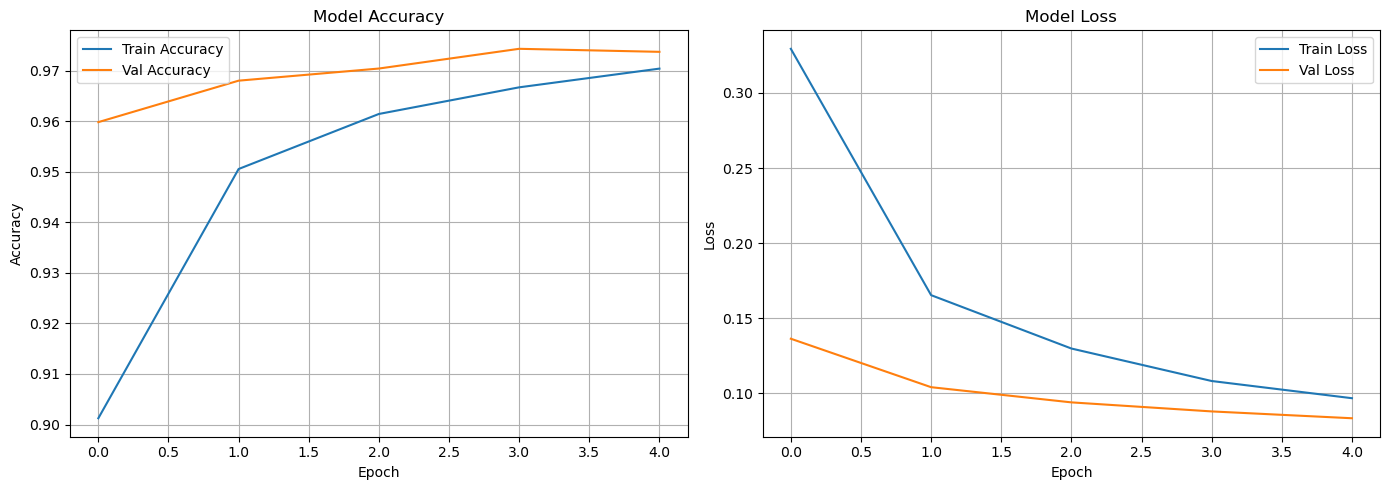

In [26]:
# Graficar accuracy y loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Val Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('Model Accuracy')
ax1.legend()
ax1.grid(True)

# Loss
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Val Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Model Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## 6. Ejemplo avanzado: Dataset desde archivos de texto

Simulamos un caso de uso con archivos de texto usando `TextLineDataset`.

In [27]:
# Crear un archivo de texto de ejemplo
import os

# Crear directorio temporal
temp_dir = "/tmp/tf_data_example"
os.makedirs(temp_dir, exist_ok=True)

# Escribir datos de ejemplo
text_file = os.path.join(temp_dir, "sample_data.txt")
with open(text_file, 'w') as f:
    for i in range(1000):
        f.write(f"This is sample text line {i}\n")

print(f"Archivo creado: {text_file}")

# Crear dataset desde archivo de texto
text_dataset = tf.data.TextLineDataset(text_file)

# Ver algunas líneas
print("\nPrimeras 5 líneas del dataset:")
for i, line in enumerate(text_dataset.take(5)):
    print(f"  {i+1}: {line.numpy().decode('utf-8')}")

Archivo creado: /tmp/tf_data_example/sample_data.txt

Primeras 5 líneas del dataset:
  1: This is sample text line 0
  2: This is sample text line 1
  3: This is sample text line 2
  4: This is sample text line 3
  5: This is sample text line 4


### Pipeline de procesamiento de texto

In [28]:
def process_text_line(line):
    """
    Procesa una línea de texto
    """
    # Convertir a lowercase
    line = tf.strings.lower(line)
    # Dividir en palabras
    words = tf.strings.split(line)
    return words

# Crear pipeline de texto
text_pipeline = text_dataset.map(
    process_text_line,
    num_parallel_calls=tf.data.AUTOTUNE
)
text_pipeline = text_pipeline.batch(5)
text_pipeline = text_pipeline.prefetch(tf.data.AUTOTUNE)

# Ver un batch procesado
print("\nBatch de palabras procesadas:")
for batch in text_pipeline.take(1):
    for words in batch:
        print(f"  {[w.decode('utf-8') for w in words.numpy()]}")


Batch de palabras procesadas:
  ['this', 'is', 'sample', 'text', 'line', '0']
  ['this', 'is', 'sample', 'text', 'line', '1']
  ['this', 'is', 'sample', 'text', 'line', '2']
  ['this', 'is', 'sample', 'text', 'line', '3']
  ['this', 'is', 'sample', 'text', 'line', '4']


## 7. Ejemplo de Dataset Sharded (múltiples archivos)

Simulamos el caso de datos distribuidos en múltiples archivos.

In [29]:
# Crear múltiples archivos (shards)
num_shards = 5
shard_files = []

for shard in range(num_shards):
    filename = os.path.join(temp_dir, f"data_shard_{shard:04d}.txt")
    shard_files.append(filename)
    
    with open(filename, 'w') as f:
        for i in range(100):
            f.write(f"Shard {shard}, line {i}\n")

print(f"Archivos creados:")
for f in shard_files:
    print(f"  {f}")

# Leer todos los shards
sharded_dataset = tf.data.TextLineDataset(shard_files)

# Contar total de líneas
total_lines = sum(1 for _ in sharded_dataset)
print(f"\nTotal de líneas en todos los shards: {total_lines}")

# Ver ejemplos de diferentes shards
print("\nEjemplos de diferentes shards:")
for i, line in enumerate(sharded_dataset.take(10)):
    print(f"  {line.numpy().decode('utf-8')}")

Archivos creados:
  /tmp/tf_data_example/data_shard_0000.txt
  /tmp/tf_data_example/data_shard_0001.txt
  /tmp/tf_data_example/data_shard_0002.txt
  /tmp/tf_data_example/data_shard_0003.txt
  /tmp/tf_data_example/data_shard_0004.txt

Total de líneas en todos los shards: 500

Ejemplos de diferentes shards:
  Shard 0, line 0
  Shard 0, line 1
  Shard 0, line 2
  Shard 0, line 3
  Shard 0, line 4
  Shard 0, line 5
  Shard 0, line 6
  Shard 0, line 7
  Shard 0, line 8
  Shard 0, line 9


## 8. Resumen y Best Practices

### Pipeline típico optimizado:

```python
dataset = tf.data.Dataset.from_tensor_slices(data)
dataset = dataset.shuffle(buffer_size)      # Evitar patrones
dataset = dataset.map(transform, num_parallel_calls=AUTOTUNE)  # Transformar en paralelo
dataset = dataset.batch(batch_size)         # Agrupar
dataset = dataset.prefetch(AUTOTUNE)        # Preparar siguiente batch
dataset = dataset.cache()                   # Opcional: cachear si cabe en memoria
```

### Ventajas de tf.data:
1. **Eficiencia de memoria**: Solo carga lo necesario
2. **Paralelización automática**: con `AUTOTUNE`
3. **GPU nunca espera**: gracias a `prefetch()`
4. **Escalabilidad**: funciona con datasets pequeños y gigantes
5. **Reusabilidad**: pipelines fáciles de mantener

In [30]:
# Limpieza
import shutil
if os.path.exists(temp_dir):
    shutil.rmtree(temp_dir)
    print("Archivos temporales eliminados")

Archivos temporales eliminados


## Conclusiones

Este notebook cubrió:

1. **Ciclo completo de ML**: extracción → análisis → preparación → entrenamiento → evaluación
2. **Feature Engineering**: normalización y transformación de datos
3. **tf.data.Dataset**: creación de pipelines eficientes
4. **Optimizaciones**: shuffle, batch, map, prefetch, cache
5. **Comparación de rendimiento**: medición de mejoras con diferentes técnicas
6. **Casos de uso avanzados**: TextLineDataset y datasets sharded
